**CharCNN-(bi)LSTM for sequence tagging**

как мы видим, задача pos-тэггинга плохо решается без морфологической информации . Ваша задача перестроить  нашу сеть так, чтобы она учитывала эту информацию. Постройте сеть, которая имела бы два input слоя:

1. Один такой же, как мы сделали, подает слова в embedding-слой, а поверх него работает (bi)lstm, проходящая по всей последовательности
2. Второй входной слой должен брать последовательность слов, каждое из которых представлено буквами (используйте паддинг для добивания каждого слова до максимальной длины слова). Таким образом второй input слой будет принимать массивы размера (batch_size, max_seq_len, max_char_len). Данные с этого input слоя должны попадать в embedding слой (на выходе (batch_size, max_seq_len, max_char_len, char_emb)), затем к ним должна применяться свертка (на выходе (batch_size, max_seq_len, ~max_char_len, kernel_size)), затем расплющивание (на выходе (batch_size, max_seq_len, ~max_char_len*kernel_size)).
 NB: чтобы слои Conv1D и Flatten возвращали указанные размерности, они должны работать на элементах последовательности, а не на всей последовательности сразу. Для этого вам понадобится обернуть их в TimeDistributed.

Полученные выходы с 1. и 2. сконкатенируйте, и пройдитесь по ним (bi)LSTM. В конце, как и в построенной нами сети, испольуйте TimeDistributed Dense слой.

Для того, чтобы можно было глазами оценить результат, напишите ф-цию, которая бы брала на вход английское предложение, например любое предложение из теста, и выводила предсказания сети в виде тэгов.

Если с построением сети совсем сложно и непонятно, вам должен помочь код вот здесь https://www.depends-on-the-definition.com/lstm-with-char-embeddings-for-ner/  (эмбеддинги символов обрабатываются не свертками, но идея очень похожая)



In [0]:
%tensorflow_version 2.x

In [2]:
cd 'drive/My Drive/colab_data'

/content/drive/My Drive/colab_data


In [3]:
import tensorflow as tf
import numpy as np
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, AlphaDropout, LSTM, GRU, Bidirectional, TimeDistributed, InputLayer, Embedding, Conv1D, Flatten, concatenate, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter, Iterable
from itertools import chain
import pandas as pd

In [0]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()

In [0]:
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(sentence)
    sentence_tags.append(tags)

In [0]:
sent_train, sent_test, tag_train, tag_test = train_test_split(sentences, sentence_tags, test_size=0.2)

In [0]:
vocab = Counter()
for sent in sent_train:
    sent = [word.lower() for word in sent]
    vocab.update(sent)

In [0]:
filtered_vocab = {word for word in vocab if vocab[word] > 5}

In [0]:
word2id = {'PAD':0, 'UNK':1}    
for i, word in enumerate(filtered_vocab):
      word2id[word] = i + 2

id2word = {i:word for word, i in word2id.items()}

In [0]:
tag2id = {'UNK': 1, 'PAD':0}  
for tags in tag_train:
    for tag in tags:
      if tag.lower() not in tag2id:
        tag2id[tag.lower()] = len(tag2id)

id2tag = {i:tag for tag, i in tag2id.items()}

In [0]:
char2id = {'UNK': 1, 'PAD':0}
chars = set(chain(*chain(*sent_train)))
chars = {ch.lower() for ch in chars}
for ch in chars:
  if ch.lower not in char2id:
    char2id[ch.lower()] = len(char2id)
id2char = {i:ch for ch, i in char2id.items()}

In [0]:
def data2ints(data, smth2id):
  int_data = []
  for seq in data:
      int_seq = []
      for i in seq:
          try:
            int_seq.append(smth2id[i.lower()])
          except KeyError:
            int_seq.append(smth2id['UNK'])
      int_data.append(int_seq)
  return int_data
 

Поскольку предложения каждый раз разбиваются по разному и длина получается разная, поэтому фиксирую конкретное максимальное значение.

In [0]:
max_seq_len = min(max(len(x) for x in sent_train), 120)

In [0]:
max_char_len = [[len(word) for word in sent] for sent in sent_train]
max_char_len = max(chain(*max_char_len))
max_char_len = min(max_char_len, 16)

In [0]:
X_train_ids, X_test_ids = data2ints(sent_train, word2id), data2ints(sent_test, word2id)
y_train_ids, y_test_ids = data2ints(tag_train, tag2id), data2ints(tag_test, tag2id)

In [0]:
X_char_train_ids = [[[char2id.get(ch.lower(), 1) for ch in word] for word in sent] for sent in sent_train]
X_char_test_ids = [[[char2id.get(ch.lower(), 1) for ch in word] for word in sent] for sent in sent_test]

In [0]:
X_train, X_test = pad_sequences(X_train_ids, maxlen=max_seq_len, padding='post'), pad_sequences(X_test_ids, maxlen=max_seq_len, padding='post')
y_train_pad, y_test_pad = pad_sequences(y_train_ids, maxlen=max_seq_len, padding='post', truncating='post'), pad_sequences(y_test_ids, maxlen=max_seq_len, padding='post', truncating='post')

In [0]:
X_char_train = pad_sequences([pad_sequences(ids, maxlen=max_char_len, padding='post') for ids in X_char_train_ids], maxlen=max_seq_len, padding='post')
X_char_test = pad_sequences([pad_sequences(ids, maxlen=max_char_len, padding='post') for ids in X_char_test_ids], maxlen=max_seq_len, padding='post')

In [0]:
y_train, y_test = to_categorical(y_train_pad, num_classes=len(tag2id)), to_categorical(y_test_pad, num_classes=len(tag2id))

In [0]:
sent_in = Input(shape=(max_seq_len,), name='sentence_input')

emb_sent = Embedding(len(word2id), 60, mask_zero=True, name='sentence_embedding')(sent_in)
lstm_sent = Bidirectional(LSTM(256, return_sequences=True), name='sentence_bi_lstm')(emb_sent)
drop_sent = AlphaDropout(0.2, name='sentence_dropout')(lstm_sent)

char_in = Input(shape=(max_seq_len, max_char_len), name='character_input')
emb_char = TimeDistributed(Embedding(len(char2id), 8, input_length=max_char_len,
                                     mask_zero=False), name='character_embedding')(char_in)

conv_char = TimeDistributed(Conv1D(128, 3, 1, padding='same'), name='character_convolution')(emb_char)
flat_char = TimeDistributed(Flatten(), name='character_flatten')(conv_char)
drop_char = AlphaDropout(0.2, name='character_dropout')(flat_char)

x = concatenate([drop_sent, drop_char], name='total_concat')
lstm = Bidirectional(LSTM(256, return_sequences=True), name='total_bi_lstm')(x)
dense = TimeDistributed(Dense(len(tag2id)*2, activation='tanh', name='dense'))(lstm)
final_drop = AlphaDropout(0.1, name='final_dropout')(dense)
out = TimeDistributed(Dense(len(tag2id), activation='softmax'), name='output_layer')(final_drop)

model = Model(inputs=[sent_in, char_in], outputs=out)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
character_input (InputLayer)    [(None, 120, 16)]    0                                            
__________________________________________________________________________________________________
sentence_input (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
character_embedding (TimeDistri (None, 120, 16, 8)   440         character_input[0][0]            
__________________________________________________________________________________________________
sentence_embedding (Embedding)  (None, 120, 60)      102240      sentence_input[0][0]             
______________________________________________________________________________________________

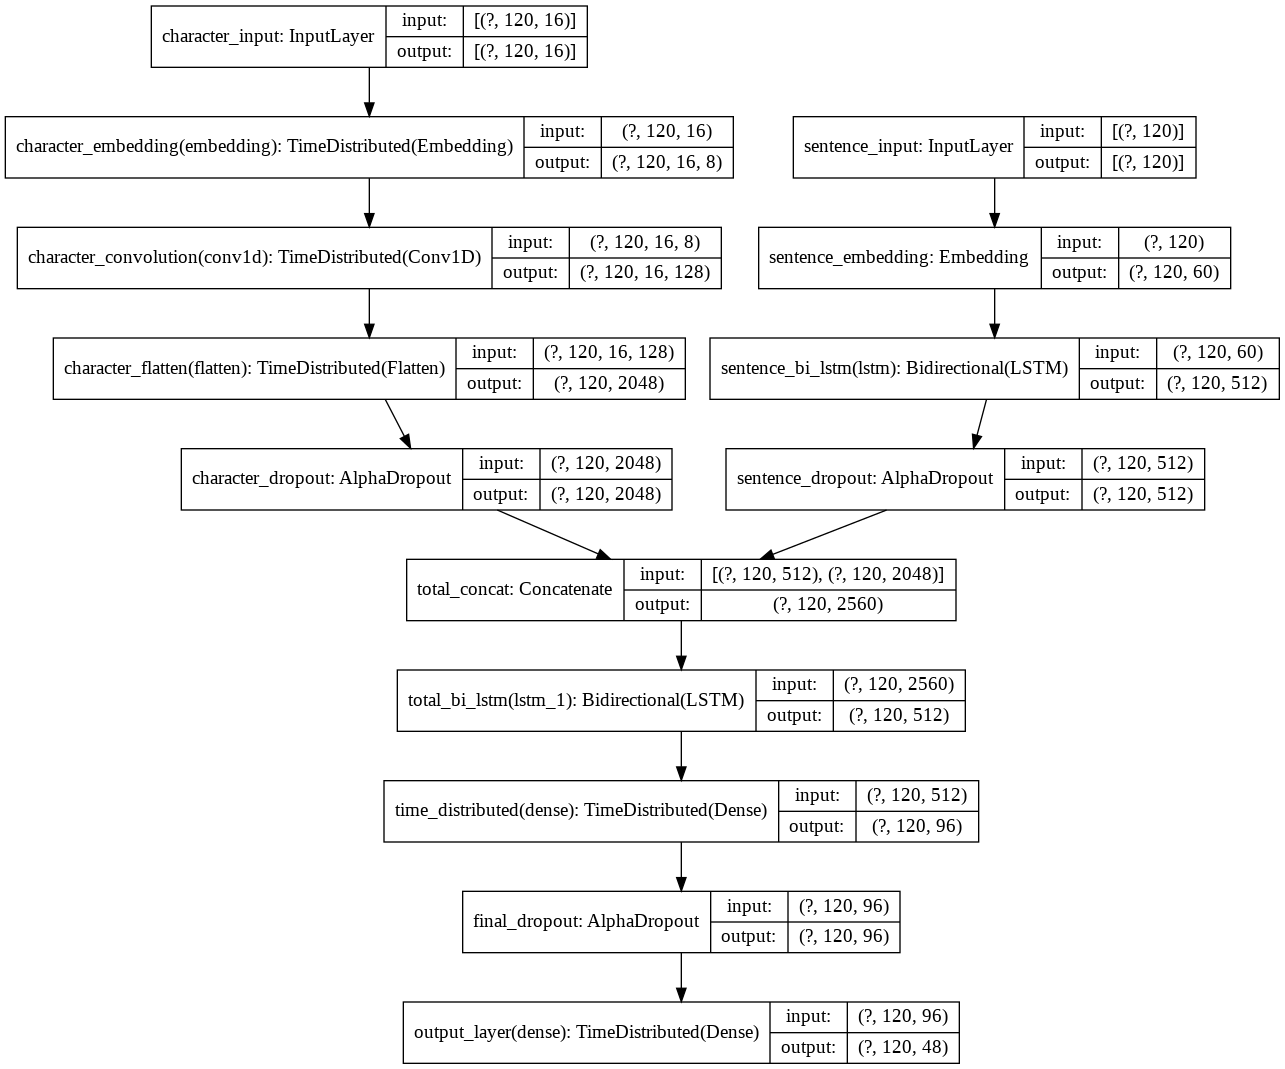

In [23]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [0]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_lstm.h5', 
                                                monitor='accuracy',
                                                verbose=1,
                                                save_weights_only=False,
                                                save_best_only=True,
                                                mode='max',
                                                save_freq='epoch')

In [27]:
history = model.fit(x=[X_train, X_char_train], y=y_train, batch_size=128,
                    epochs=64, callbacks=[checkpoint],
                    validation_data=([X_test, X_char_test], y_test),
                    shuffle=True)

Epoch 1/64
25/25 [==============================] - ETA: 0s - loss: 0.7517 - accuracy: 0.0336
Epoch 00001: accuracy improved from -inf to 0.03355, saving model to model_lstm.h5
25/25 [==============================] - 12s 489ms/step - loss: 0.7517 - accuracy: 0.0336 - val_loss: 0.6379 - val_accuracy: 0.0357
Epoch 2/64
25/25 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.0457
Epoch 00002: accuracy improved from 0.03355 to 0.04575, saving model to model_lstm.h5
25/25 [==============================] - 3s 128ms/step - loss: 0.6509 - accuracy: 0.0457 - val_loss: 0.6217 - val_accuracy: 0.0374
Epoch 3/64
25/25 [==============================] - ETA: 0s - loss: 0.6355 - accuracy: 0.0498
Epoch 00003: accuracy improved from 0.04575 to 0.04978, saving model to model_lstm.h5
25/25 [==============================] - 3s 128ms/step - loss: 0.6355 - accuracy: 0.0498 - val_loss: 0.6174 - val_accuracy: 0.0374
Epoch 4/64
25/25 [==============================] - ETA: 0s - loss: 0

Как выяснилось, если не ограничивать длину слов и предложений сверху, то результат получается значительно хуже.

In [0]:
hist = pd.DataFrame(history.history)

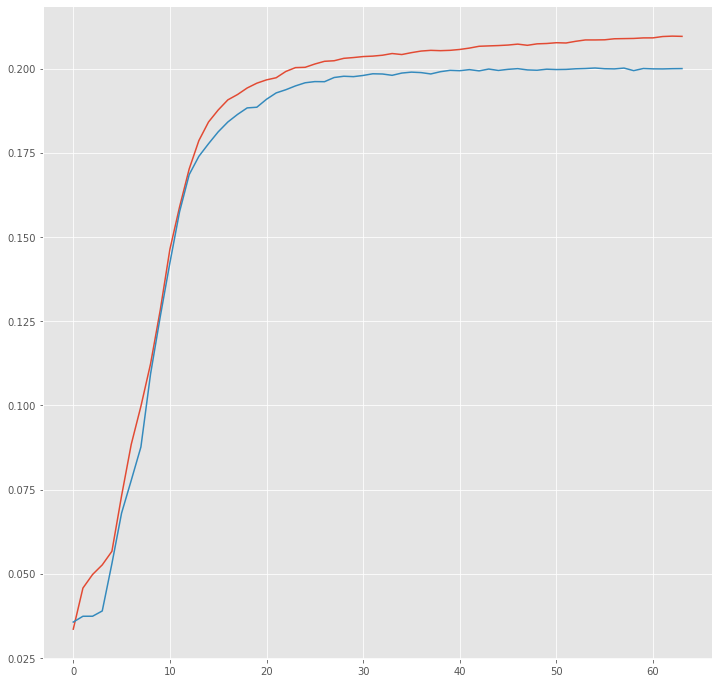

In [29]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

Загрузим самую успешную модель

In [0]:
model = tf.keras.models.load_model('model_lstm.h5')

Функция для тэггинга одного предложения

In [31]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def tag_sentence(sentence):
  if isinstance(sentence, str):
    sentence = word_tokenize(sentence)
  if not isinstance(sentence, Iterable):
    raise TypeError('Input must be a string or an iterable of tokens.')
  else:
    sent_len = len(sentence)
    sent_char = [[[char2id.get(ch.lower(), 1) for ch in word] for word in sent] for sent in [sentence]]
    sent_char = pad_sequences([pad_sequences(ids, maxlen=max_char_len, padding='post') for ids in sent_char], maxlen=max_seq_len, padding='post')
    sent_word = [word2id.get(word.lower(), 1) for word in sentence]
    sent_word = pad_sequences([sent_word], maxlen=max_seq_len, padding='post')
    pred = model.predict([sent_word, sent_char])
    pred = [id2tag[tag] for tag in np.argmax(pred, axis=2)[0, :sent_len]]
    return list(zip(sentence, pred))

In [33]:
tag_sentence(sent_train[np.random.randint(0, len(sent_test) + 1)])

[('And', 'cc'),
 ('it', 'prp'),
 ('*EXP*-2', '-none-'),
 ('is', 'vbz'),
 ("n't", 'rb'),
 ('clear', 'jj'),
 ('that', 'in'),
 ('the', 'dt'),
 ('Soviet', 'nnp'),
 ('Union', 'nnp'),
 ('will', 'md'),
 ('stay', 'vb'),
 ('on', 'in'),
 ('its', 'prp$'),
 ('record', 'nn'),
 ('buying', 'vbg'),
 ('pace', 'nn'),
 ('.', '.')]

In [34]:
tag_sentence(sent_train[np.random.randint(0, len(sent_test) + 1)])

[('``', '``'),
 ('The', 'dt'),
 ('sound', 'nn'),
 ('of', 'in'),
 ('bells', 'nns'),
 ('is', 'vbz'),
 ('a', 'dt'),
 ('net', 'nn'),
 ('0', '-none-'),
 ('*T*-1', '-none-'),
 ('to', 'to'),
 ('draw', 'vb'),
 ('people', 'nns'),
 ('into', 'in'),
 ('the', 'dt'),
 ('church', 'nn'),
 (',', ','),
 ("''", "''"),
 ('he', 'prp'),
 ('says', 'vbz'),
 ('*T*-2', '-none-'),
 ('.', '.')]

In [35]:
tag_sentence('Some random test sentence here, examples of punctuation are also available!.')

[('Some', 'dt'),
 ('random', 'nnp'),
 ('test', 'nnp'),
 ('sentence', 'nnp'),
 ('here', 'rb'),
 (',', ','),
 ('examples', 'nns'),
 ('of', 'in'),
 ('punctuation', 'nn'),
 ('are', 'vbp'),
 ('also', 'rb'),
 ('available', 'jj'),
 ('!', '.'),
 ('.', '.')]